#  Better Categories for Level, Category and Tiers for Suppliers

In [1]:
import numpy as np
import pandas as pd
import os
import sys

home_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(0, home_dir)
from util import db, nlp

In [26]:
import difflib

from fuzzywuzzy import process

from fuzzywuzzy import fuzz

In [172]:
import pickle

_Keep Track of manually labelled Tiers, Categories, etc_ <br>
https://theedge.sharepoint.com/:x:/r/sites/at/_layouts/15/Doc.aspx?sourcedoc=%7BD70B3C31-42D9-4DF5-B4D9-FFD47E732E8D%7D&file=PowerBI%20Word%20Bank.xlsx&action=default&mobileredirect=true

## Supplier Tiers

In [49]:
conn = db.open_conn(is_prod=True)

In [2]:
v_services = db.get_table_pd(f"SELECT * FROM v_Services", conn)
accounts = db.get_table_pd('SELECT * FROM SFDC.Account', conn)

In [68]:
v_services.to_csv('v_services.csv', index=False)

### Matching suppliers to Salesforce account information

In [62]:
suppliers = pd.DataFrame(data = list(set(v_services['service provider'].str.lower())), columns = ['supplier'])

In [70]:
accounts.name = accounts.name.str.lower()

suppliers['matches_dl'] = suppliers.supplier.apply(lambda x: difflib.get_close_matches(x, accounts.name))

suppliers['matches_fuzz'] = suppliers.supplier.apply(lambda x: [r[0] for r in process.extract(x, accounts.name.tolist(), limit=3)])

suppliers['matches_token_set'] = suppliers.supplier.apply(lambda x: [r[0] for r in process.extract(x, accounts.name.tolist(), limit=3, scorer=fuzz.token_set_ratio)])

suppliers['matches_partial_ratio'] = suppliers.supplier.apply(lambda x: [r[0] for r in process.extract(x, accounts.name.tolist(), limit=3, scorer=fuzz.partial_ratio)])

In [173]:
with open('unique_suppliers.p', 'wb') as fh:
   pickle.dump(suppliers, fh)

In [174]:
#pd.pickle

In [164]:
accounts.name[['harvard' in a for a in accounts.name]]

2746                                    harvard university
2973                                    harvard bioscience
3672                           harvard pilgrim health care
11400    harvard business school - harvard business pub...
Name: name, dtype: string

In [169]:
suppliers[['harvard' in a for a in suppliers.supplier]]

,supplier,matches_dl,matches_fuzz,matches_token_set,matches_partial_ratio
32,harvard partners,"[venator partners, artisan partners, g&a partn...","[sandler o'neill & partners l.p., pjt partners...","[bgc partners, noe partners, g&a partners]","[gartner, g&a partners, st. john and partners]"


### Extracting Level, Category, Service Provider, OEM Company

Get All Unique Entries for OEM, Category and Service Provider

In [ ]:
oem = [str(s).lower() for s in set(v_services['oem company'])]


In [ ]:
cats = [str(s).lower() for s in set(v_services['category'])]

In [8]:
# nlp.write_list_csv('suppliers.csv',np.sort(np.array(v_services['service provider'].value_counts().index)))

# nlp.write_list_csv('oem.csv',np.sort(np.array(v_services['oem company'].value_counts().index)))

# nlp.write_list_csv('category.csv',np.sort(np.array(v_services['category'].value_counts().index)))

### Tiers 1,2 from Jake/Kevin

In [54]:
sup_tiered = pd.read_excel('supplier_tiers.xlsx').dropna(how='all',axis=1)

In [55]:
sup_tiered.supplier = sup_tiered.supplier.str.lower()

In [56]:
v_services['supplier'] =v_services['service provider'].str.lower()

In [57]:
v_services['quote_low'] = pd.to_numeric(v_services['quoted rate low'])

In [58]:
co_tran = {'allegis': 'allegis global solutions',
 'aws': 'amazon',
 'bain':'bain & company',
 'bcg':"boston consulting group",
 'dell':'dxc',
 'emc':'dell emc',
 'ey':'ernst & young',
 'hpe':'hewlett packard enterprise (hpe)',
 'insight':'insight global',
 'mckinsey':'mcKinsey & company',
 'mu sigma':'mu sigma inc.',
 'shi':'software house international - shi',
 'tech mahindra':'tech mahindra limited',
 'tek systems':'teksystems',
 'wwt':'wwt (var)'}
sup_tiered.replace(co_tran, inplace=True)

In [63]:
sup_merged = suppliers.merge(sup_tiered, on='supplier', how='left')

In [66]:
sup_merged.to_csv('sup_tier_merged.csv')

In [14]:
sup_notier = sup_merged[sup_merged.Tier.isnull()]

In [15]:
cases_notier = v_services[[s in list(sup_notier.supplier) for s in v_services.supplier]].copy()

### Histograms of Unalabelled Suppliers

In [16]:
import matplotlib.pyplot as plt

In [17]:
cases_notier['quote_low'] = pd.to_numeric(cases_notier['quoted rate low'])

Text(0.5, 1.0, 'Quoted Rates')

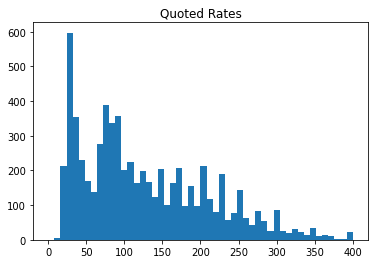

In [18]:
plt.hist(cases_notier['quoted rate low'],range=(0,400), bins = 50)
plt.title('Quoted Rates')

In [23]:
sup_rate = cases_notier[['supplier','quote_low']]
sup_rate_mean = sup_rate.groupby('supplier').mean()['quote_low']

Text(0.5, 1.0, 'Mean Quoted Rate for each Supplier')

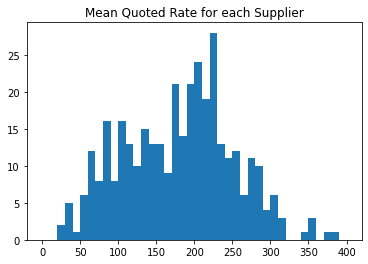

In [24]:
plt.hist(sup_rate_mean.values, range=(0,400),bins=40)
plt.title('Mean Quoted Rate for each Supplier')

#### Broken up by Practices

In [300]:
third_p = list(cases_notier.quote_low[cases_notier.practice == "Third Party Labor" ])
prof_ser = list(cases_notier.quote_low[cases_notier.practice == "Professional Services" ])
man_ser = list(cases_notier.quote_low[cases_notier.practice == "Managed Services" ])

Text(0.5, 1.0, 'Quoted Rate Hist.')

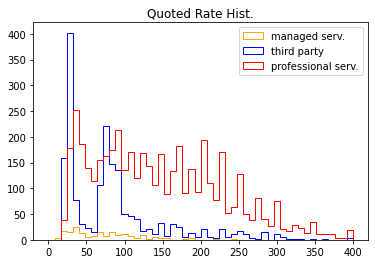

In [307]:
plt.hist([prof_ser, third_p, man_ser], color=['red','blue','orange'],
         label=['professional serv.', 'third party', 'managed serv.'],
        range=(0,400), bins = 50,
        histtype='step')
plt.legend()
plt.title('Quoted Rate Hist.')

In [334]:
supplier_pract_quote = cases_notier[['supplier','practice','quote_low']].groupby(['supplier','practice']).mean()['quote_low']


In [342]:
sup_third = supplier_pract_quote[supplier_pract_quote.index.get_level_values('practice').isin(['Third Party Labor'])].values
sup_prof = supplier_pract_quote[supplier_pract_quote.index.get_level_values('practice').isin(['Professional Services'])].values
sup_man = supplier_pract_quote[supplier_pract_quote.index.get_level_values('practice').isin(['Managed Services'])].values

Text(0.5, 1.0, 'Quoted Rate Hist.')

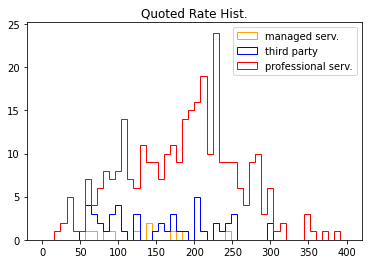

In [344]:
plt.hist([sup_prof, sup_third, sup_man], color=['red','blue','orange'],
         label=['professional serv.', 'third party', 'managed serv.'],
        range=(0,400), bins = 50,
        histtype='step')
plt.legend()
plt.title('Quoted Rate Hist.')

####  Country

In [33]:
cases_notier.country = cases_notier.country.str.lower()

In [317]:
us_mask = ['usa' in c for c in cases_notier.country]
in_mask = ['india' in c for c in cases_notier.country]
canada_mask = ['canada' in c for c in cases_notier.country]
other_mask = [not i and not u and not c for u,i,c in zip(us_mask,in_mask, canada_mask)]

In [318]:
us_quotes = cases_notier.quote_low[['usa' in c for c in cases_notier.country]].values
india_quotes = cases_notier.quote_low[['india' in c for c in cases_notier.country]].values
canada_q = cases_notier.quote_low[['canada' in c for c in cases_notier.country]].values
other_off = cases_notier.quote_low[other_mask].values

Text(0.5, 1.0, 'Quoted Rate Hist.')

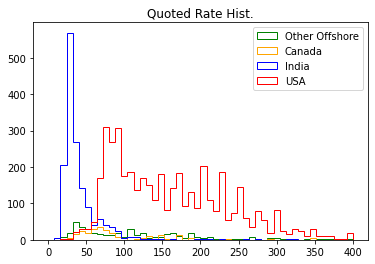

In [321]:
plt.hist([us_quotes, india_quotes, canada_q, other_off], color=['red','blue','orange', 'green'],
         label=['USA', 'India', 'Canada', 'Other Offshore'],
        range=(0,400), bins = 50,
        histtype='step')
plt.legend()
plt.title('Quoted Rate Hist.')

In [34]:
sup_country_quote = cases_notier[['supplier','country','quote_low']].groupby(['supplier','country']).mean()

In [354]:
us_sup_m = ['usa' in c for c in sup_country_quote.index.get_level_values('country')]
in_sup_m = ['india' in c for c in sup_country_quote.index.get_level_values('country')]
other_sup_m = [not i and not u  for u,i in zip(us_sup_m,in_sup_m)]

In [362]:
us_sup_q = sup_country_quote[us_sup_m]['quote_low'].values
in_sup_q = sup_country_quote[in_sup_m]['quote_low'].values
other_sup_q = sup_country_quote[other_sup_m]['quote_low'].values

Text(0.5, 1.0, 'Quoted Rate Hist.')

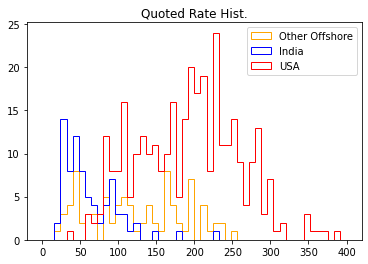

In [363]:
plt.hist([us_sup_q, in_sup_q, other_sup_q], color=['red','blue','orange'],
         label=['USA', 'India', 'Other Offshore'],
        range=(0,400), bins = 50,
        histtype='step')
plt.legend()
plt.title('Quoted Rate Hist.')

## Clustering of Unlabeled Suppliers

     Clustering suppliers based on their mean quote price and country of labor

### Create DF with Dummy Country Variables and Normalize Rate

In [57]:
from sklearn.preprocessing import StandardScaler

In [36]:
us_sup_m = ['usa' in c for c in sup_country_quote.index.get_level_values('country')]
in_sup_m = ['india' in c for c in sup_country_quote.index.get_level_values('country')]

In [48]:
sup_country_quote['in_us'] = us_sup_m
sup_country_quote['in_india'] = in_sup_m
sup_country_quote['supplier'] = sup_country_quote.index.get_level_values('supplier')

In [54]:
sup_country_quote.reset_index(drop=True, inplace=True)

In [63]:
sup_country_quote

,quote_low,in_us,in_india,supplier,quote_scaled
0,175.000000,True,False,accutive,0.138553
1,209.437500,True,False,aci worldwide,0.541394
2,220.000000,True,False,active cyber,0.664952
3,105.000000,True,False,adroit resources,-0.680289
4,141.426667,True,False,adt,-0.254179
...,...,...,...,...,...
520,107.666667,True,False,zentest,-0.649095
521,45.206897,False,False,zoolatech,-1.379734
522,110.206897,True,False,zoolatech,-0.619380
523,183.285714,False,True,zs associates,0.235477


In [58]:
scaler = StandardScaler()

In [60]:
quoted_scaled =scaler.fit_transform(np.array(sup_country_quote['quote_low']).reshape(-1,1)).reshape(len(sup_country_quote))

In [62]:
sup_country_quote['quote_scaled'] = quoted_scaled

### Gaussian Mixture Models

__Why some suppliers with na mean quote?__

In [86]:
sup_country_quote.dropna(inplace=True)

In [90]:
X_sup = sup_country_quote[['quote_scaled','in_us','in_india']].astype('float').values

#### Three Dimensions

In [91]:
X_q=sup_country_quote.quote_scaled.values
X_us=sup_country_quote.in_us.values
X_in=sup_country_quote.in_india.values

In [97]:
g1_mask = groups == 0
g2_mask = groups ==1
g3_mask = groups == 2

Text(0.5, 0, 'India')

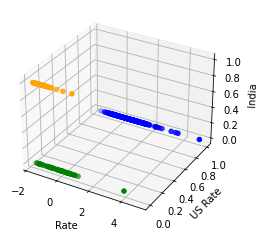

In [102]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_q[g1_mask], X_us[g1_mask], X_in[g1_mask], color = 'blue')
ax.scatter(X_q[g2_mask], X_us[g2_mask], X_in[g2_mask], color = 'orange')
ax.scatter(X_q[g3_mask], X_us[g3_mask], X_in[g3_mask], color='green')
ax.set_xlabel('Rate')
ax.set_ylabel('US Rate')
ax.set_zlabel('India')

In [66]:
from sklearn.mixture import GaussianMixture

In [77]:
gm = GaussianMixture(n_components=3, random_state=0).fit(X_sup)

In [94]:
groups = gm.predict(X_sup)

#### One Dimension Cluster

##### Two Clusters

In [105]:
gm_d1 = GaussianMixture(n_components=2, random_state=0).fit(X_q.reshape(-1,1))

In [106]:
d1_groups = gm_d1.predict(X_q.reshape(-1,1))

g1d1_mask = d1_groups==0
g2d1_mask = d1_groups==1

Text(0.5, 1.0, 'Hist. GMM Clustered')

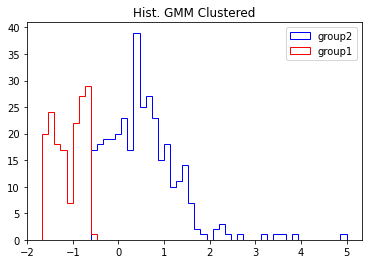

In [110]:
plt.hist([X_q[g1d1_mask],X_q[g2d1_mask]], color=['red','blue'],
         label=['group1', 'group2'],
         bins=50,
        histtype='step')
plt.legend()
plt.title('Hist. GMM Clustered')

##### Three Clusters

In [111]:
gm_d13 = GaussianMixture(n_components=3, random_state=0).fit(X_q.reshape(-1,1))

In [115]:
d1_groups = gm_d13.predict(X_q.reshape(-1,1))

g1d1_mask = d1_groups==0
g2d1_mask = d1_groups==1
g3d1_mask = d1_groups==2

Text(0.5, 1.0, 'Hist. GMM Clustered')

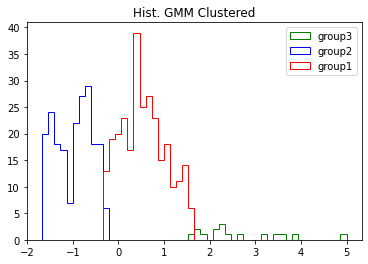

In [116]:
plt.hist([X_q[g1d1_mask],X_q[g2d1_mask],X_q[g3d1_mask]], color=['red','blue', 'green'],
         label=['group1', 'group2', 'group3'],
         bins=50,
        histtype='step')
plt.legend()
plt.title('Hist. GMM Clustered')

##### Four Clusters

In [123]:
gm_d1 = GaussianMixture(n_components=4, random_state=0).fit(X_q.reshape(-1,1))

In [124]:
d1_groups = gm_d1.predict(X_q.reshape(-1,1))

g1d1_mask = d1_groups==0
g2d1_mask = d1_groups==1
g3d1_mask = d1_groups==2
g4d1_mask = d1_groups==3

Text(0.5, 1.0, 'Hist. GMM Clustered')

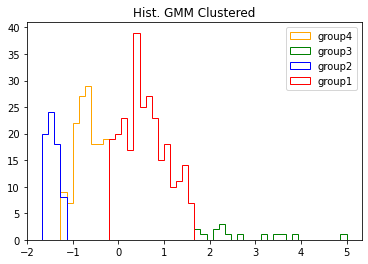

In [128]:
plt.hist([X_q[g1d1_mask],X_q[g2d1_mask],X_q[g3d1_mask],X_q[g4d1_mask]], color=['red','blue', 'green', 'orange'],
         label=['group1','group2','group3','group4'],
         bins=50,
        histtype='step')
plt.legend()
plt.title('Hist. GMM Clustered')

## Clustering of all Suppliers

In [141]:
all_mean = v_services[['supplier','quote_low']].dropna().groupby('supplier').mean()

In [142]:
means = all_mean['quote_low'].values
gm4_all = GaussianMixture(n_components=4, random_state=0).fit(means.reshape(-1,1))

In [236]:
d1_groups = gm4_all.predict(means.reshape(-1,1))

g1d1_mask = d1_groups==0
g2d1_mask = d1_groups==1
g3d1_mask = d1_groups==2
g4d1_mask = d1_groups==3

Text(0.5, 1.0, 'Hist. GMM Clustered')

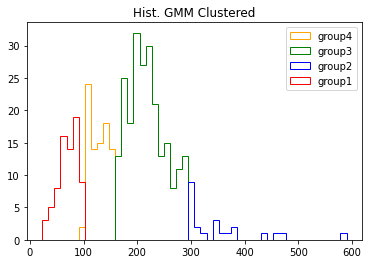

In [237]:
plt.hist([means[g1d1_mask],means[g2d1_mask],means[g3d1_mask],means[g4d1_mask]], color=['red','blue', 'green', 'orange'],
         label=['group1','group2','group3','group4'],
         bins=50,
        histtype='step')
plt.legend()
plt.title('Hist. GMM Clustered')

### TFIDF of Title by Supplier

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vec = TfidfVectorizer(max_features=1000)

In [180]:
v_services_dropna = v_services[['supplier','full position title', 'quote_low']].dropna()

In [182]:
sup_position = v_services_dropna[['supplier', 'full position title']].groupby('supplier')['full position title'].apply(' '.join)

In [185]:
X_pos = tf_vec.fit_transform(sup_position.values)

In [232]:
pd.DataFrame(data=X_pos.todense(), columns=tf_vec.get_feature_names()).sum().sort_values(ascending=False)[0:15]

Index(['consultant', 'senior', 'engineer', 'manager', 'project', 'architect',
       'analyst', 'lead', 'developer', 'technical', 'service', 'business',
       'management', 'sr', 'solution'],
      dtype='object')

In [187]:
gm_pos = GaussianMixture(n_components=4, random_state=0).fit(X_pos.todense())

In [188]:
d1_groups = gm_pos.predict(X_pos.todense())

g1d1_mask = d1_groups==0
g2d1_mask = d1_groups==1
g3d1_mask = d1_groups==2
g4d1_mask = d1_groups==3

Text(0.5, 1.0, 'Hist. GMM Clustered')

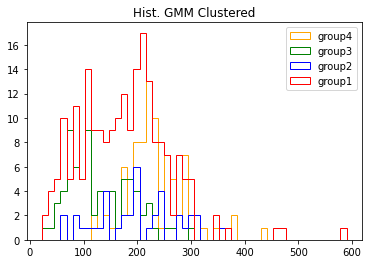

In [189]:
plt.hist([means[g1d1_mask],means[g2d1_mask],means[g3d1_mask],means[g4d1_mask]], color=['red','blue', 'green', 'orange'],
         label=['group1','group2','group3','group4'],
         bins=50,
        histtype='step')
plt.legend()
plt.title('Hist. GMM Clustered')

In [206]:
sup_tf_groups = pd.DataFrame({'supplier': sup_position.index, 'group':d1_groups})

In [ ]:
sup_tiered.merge(sup_tf_groups, on='supplier')

#### Get Most important words for each group

In [221]:
pos_tfidf = pd.DataFrame(data=X_pos.todense(), columns=tf_vec.get_feature_names())

In [226]:
pos_tfidf_g1 = pos_tfidf[g1d1_mask]
pos_tfidf_g2 = pos_tfidf[g2d1_mask]
pos_tfidf_g3 = pos_tfidf[g3d1_mask]
pos_tfidf_g4 = pos_tfidf[g4d1_mask]

In [235]:
pos_tfidf_g4.sum().sort_values(ascending=False)[0:20]

consultant        31.603385
senior            13.639985
manager           11.631057
project            9.315778
solution           8.326953
architect          8.194117
technical          6.398290
principal          5.723508
sr                 4.730958
associate          4.025671
offshore           3.500330
lead               2.942978
business           2.534106
delivery           2.435411
implementation     2.293639
specialist         2.161546
partner            2.111956
director           2.101238
engagement         2.037680
management         1.942900
dtype: float64

In [220]:
v_services.to_csv('v_services.csv',index=False)

#### Category

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
cv_big = CountVectorizer(ngram_range=(2,2))
X = cv_big.fit_transform([str(c) for c in v_services['category']])

In [36]:
count_cat = pd.DataFrame(data=X.todense(),columns=cv_big.get_feature_names())

In [42]:
cat_bigrams = count_cat.sum().sort_values(ascending=False)

In [60]:
cat_tokens = nlp.tokenize_col(v_services['category'].dropna())

In [70]:
cat_oneword = [t for t in cat_tokens if len(t) < 2 and len(t)>0]

In [ ]:
cat_oneword_s = pd.Series([t[0] for t in cat_oneword]).value_counts()
cat_oneword_s[cat_oneword_s>20]